In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP, MLP
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

import numpy as np
import copy 
import time
from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import trange
from scipy.sparse.csgraph import connected_components
import pickle
import os


In [2]:
import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import argparse
"""
Dataset arguments
"""
parser = argparse.ArgumentParser(
    description='Training GCN on Large-scale Graph Datasets')
parser.add_argument('--dataset', type=str, default='citeseer',
                    help='Dataset name: pubmed/flickr/reddit/ppi-large')
parser.add_argument('--method', type=str, default='GCN/ResGCN/GCNII/DropEdge/PairNorm', # SGC/GCN/GCNBias/ResGCN/GCNII/APPNP
                    help='Algorithms: seperate using slash')
parser.add_argument('--nhid', type=int, default=64,
                    help='Hidden state dimension')
parser.add_argument('--epoch_num', type=int, default=500,
                    help='Number of Epoch')
parser.add_argument('--batch_size', type=int, default=20000000,
                    help='size of output node in a batch')
parser.add_argument('--n_layers', type=int, default=5,
                    help='Number of GCN layers')
parser.add_argument('--dropout', type=float, default=0,
                    help='Dropout rate')
parser.add_argument('--cuda', type=int, default=1,
                    help='Avaiable GPU ID')
args = parser.parse_args()
print(args)

method = args.method.split('/')

"""
Prepare devices
"""
if args.cuda != -1:
    device = torch.device("cuda:" + str(args.cuda))
else:
    device = torch.device("cpu")
    
if args.dataset not in ['cora', 'citeseer', 'pubmed']:
    temp_data = load_data(args.dataset) 
else:
    temp_data = load_data_gcn(args.dataset)

adj_full, adj_train, feat_data, labels, role = process_graph_data(*temp_data)

train_nodes = np.array(role['tr'])
valid_nodes = np.array(role['va'])
test_nodes = np.array(role['te'])

data_loader = DataLoader(adj_full, train_nodes, valid_nodes, test_nodes, device)

Namespace(batch_size=20000000, cuda=1, dataset='citeseer', dropout=0, epoch_num=500, method='GCN/ResGCN/GCNII/DropEdge/PairNorm', n_layers=5, nhid=64)


In [3]:
# def weight_constaint(model):
#     for p in model.parameters():
#         if p.data.norm(2) > 20:
#             p.data = p.data / p.data.norm(2)

In [4]:
"""
Setup datasets and models for training (multi-class use sigmoid+binary_cross_entropy, use softmax+nll_loss otherwise)
"""

if args.dataset in ['flickr', 'reddit', 'cora', 'citeseer', 'pubmed']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.LongTensor(labels.argmax(1))
    num_classes = labels_th.max().item()+1
    criterion = nn.CrossEntropyLoss()
    multi_class=False
elif args.dataset in ['ppi', 'ppi-large', 'amazon', 'yelp']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.FloatTensor(labels)
    num_classes = labels_th.shape[1]
    criterion = nn.BCEWithLogitsLoss()
    multi_class=True

feat_data_th = feat_data_th.to(device)
labels_th = labels_th.to(device)

def sgd_step(net, optimizer, feat_data, labels, train_data, device):
    """
    Function to updated weights with a SGD backpropagation
    args : net, optimizer, train_loader, test_loader, loss function, number of inner epochs, args
    return : train_loss, test_loss, grad_norm_lb
    """
    net.train()
    epoch_loss = []
    epoch_acc = []
    
    # Run over the train_loader
    mini_batches, adj = train_data
    for mini_batch in mini_batches:

        # compute current stochastic gradient
        optimizer.zero_grad()
        output = net(feat_data, adj)
        
        loss = net.criterion(output[mini_batch], labels[mini_batch])
        loss.backward()
        
        optimizer.step()
        epoch_loss.append(loss.item())
        
        if multi_class:
            output[output > 0.5] = 1
            output[output <= 0.5] = 0
        else:
            output = output.argmax(dim=1)

        acc = f1_score(output[mini_batch].detach().cpu(), 
                       labels[mini_batch].detach().cpu(), average="micro")
        epoch_acc.append(acc)

    return epoch_loss, epoch_acc

@torch.no_grad()
def inference(eval_model, feat_data, labels, test_data, device):
    eval_model = eval_model.to(device)
    mini_batch, adj = test_data    
    output = eval_model(feat_data, adj)
    loss = eval_model.criterion(output[mini_batch], labels[mini_batch]).item()
    
    if multi_class:
        output[output > 0.5] = 1
        output[output <= 0.5] = 0
    else:
        output = output.argmax(dim=1)
        
    acc = f1_score(output[mini_batch].detach().cpu(), 
                   labels[mini_batch].detach().cpu(), average="micro")
    return loss, acc

In [5]:
from collections import OrderedDict
def copy_model(model):
    state_dict = {k:v.to('cpu') for k, v in model.named_parameters()}
    state_dict = OrderedDict(state_dict)
    return state_dict
def copy_grad(model):
    state_dict = {k:v.grad.to('cpu') for k, v in model.named_parameters()}
    state_dict = OrderedDict(state_dict)
    return state_dict

In [6]:
"""
Train without sampling
"""

def train_model(model, data_loader, note, dropedge=1):
    train_model = copy.deepcopy(model).to(device)
    
    results = ResultRecorder(note=note)
    
    optimizer = optim.Adam(train_model.parameters())

    tbar = trange(args.epoch_num, desc='Training Epochs')
    for epoch in tbar:
        # fetch train data 
        
        sample_time_st = time.perf_counter()
        if dropedge<1:
            train_data = data_loader.get_mini_batch_dropedge(dropedge)
        else:
            train_data = data_loader.get_mini_batches(batch_size=args.batch_size)
        sample_time = time.perf_counter() - sample_time_st
        
        compute_time_st = time.perf_counter()
        train_loss, train_acc = sgd_step(train_model, optimizer, feat_data_th, labels_th, train_data, device)
        compute_time = time.perf_counter() - compute_time_st
        
        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)

        valid_data = data_loader.get_valid_batch()
        epoch_valid_loss, epoch_valid_acc = inference(train_model, feat_data_th, labels_th, valid_data, device)
        tbar.set_postfix(loss=epoch_train_loss,
                         val_loss=epoch_valid_loss,
                         val_score=epoch_valid_acc)

        results.update(epoch_train_loss, 
                       epoch_train_acc,
                       epoch_valid_loss, 
                       epoch_valid_acc, 
                       train_model, sample_time=sample_time, compute_time=compute_time)
        
    
    print('Average sampling time %.5fs, average computing time %.5fs'%
          (np.mean(results.sample_time), np.mean(results.compute_time)))
    
    return results

In [7]:
class PairNorm(nn.Module):
    def __init__(self, mode='PN', scale=1):
        super(PairNorm, self).__init__()
        self.mode = mode
        self.scale = scale
                
    def forward(self, x):
        if self.mode == 'None':
            return x
        
        col_mean = x.mean(dim=0)      
        if self.mode == 'PN':
            x = x - col_mean
            rownorm_mean = (1e-6 + x.pow(2).sum(dim=1).mean()).sqrt() 
            x = self.scale * x / rownorm_mean

        return x


In [8]:
import math

class GCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion):
        from layers import GraphConv
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion

    def forward(self, x, adj):
        x = self.linear_in(x)
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
            x = self.relu(x)
            x = self.dropout(x)
        x = self.linear_out(x)
        return x
    
class PairNorm(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion, scale):
        from layers import GraphConv
        super(PairNorm, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion
        self.scale = scale

    def norm(self, x):
        col_mean = x.mean(dim=0)      
        x = x - col_mean
        rownorm_mean = (1e-6 + x.pow(2).sum(dim=1).mean()).sqrt() 
        x = self.scale * x / rownorm_mean
        return x
            
    def forward(self, x, adj):
        x = self.linear_in(x)
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
            x = self.norm(x)
            x = self.relu(x)
            x = self.dropout(x)
        x = self.linear_out(x)
        return x

In [9]:

result_dict = {}
if 'GCN' in method:
    results_list = []
    for repeat in range(10):
        model = GCN(n_feat=feat_data.shape[1], 
                    n_hid=args.nhid, 
                    n_classes=num_classes, 
                    n_layers=args.n_layers, 
                    dropout=args.dropout, 
                    criterion=criterion)

        results = train_model(model, data_loader, note="GCN (L=%d, repeat=%d)"%(args.n_layers, repeat))
        results_list.append(results)
    result_dict['GCN'] = results_list
    
if 'PairNorm' in method:
    for scale in [0.1, 1, 10]:
        results_list = []
        for repeat in range(10):
            model = PairNorm(n_feat=feat_data.shape[1], 
                        n_hid=args.nhid, 
                        n_classes=num_classes, 
                        n_layers=args.n_layers, 
                        dropout=args.dropout, 
                        criterion=criterion, scale=scale)

            results = train_model(model, data_loader, note="PairNorm (L=%d, repeat=%d)"%(args.n_layers, repeat))
            results_list.append(results)
        result_dict['PairNorm%.1f'%scale] = results_list

Training Epochs:   2%|▏         | 9/500 [00:00<00:06, 81.69it/s, loss=1.73, val_loss=1.73, val_score=0.38] 

Average sampling time 0.00007s, average computing time 0.00779s


Training Epochs:   2%|▏         | 9/500 [00:00<00:06, 81.60it/s, loss=1.74, val_loss=1.73, val_score=0.216]

Average sampling time 0.00006s, average computing time 0.00778s


Training Epochs:   2%|▏         | 9/500 [00:00<00:05, 84.07it/s, loss=1.74, val_loss=1.73, val_score=0.196]

Average sampling time 0.00006s, average computing time 0.00776s


Training Epochs:   2%|▏         | 8/500 [00:00<00:06, 77.15it/s, loss=1.75, val_loss=1.75, val_score=0.382]

Average sampling time 0.00007s, average computing time 0.00774s


Training Epochs:   2%|▏         | 8/500 [00:00<00:06, 77.19it/s, loss=1.76, val_loss=1.75, val_score=0.354]

Average sampling time 0.00007s, average computing time 0.00777s


Training Epochs:   2%|▏         | 8/500 [00:00<00:06, 76.58it/s, loss=1.75, val_loss=1.75, val_score=0.336]

Average sampling time 0.00007s, average computing time 0.00776s


Training Epochs:   2%|▏         | 8/500 [00:00<00:06, 78.53it/s, loss=1.75, val_loss=1.75, val_score=0.266]

Average sampling time 0.00007s, average computing time 0.00779s


Training Epochs:   2%|▏         | 8/500 [00:00<00:06, 78.28it/s, loss=1.73, val_loss=1.73, val_score=0.216]

Average sampling time 0.00007s, average computing time 0.00777s


Training Epochs:   2%|▏         | 9/500 [00:00<00:05, 85.25it/s, loss=1.74, val_loss=1.73, val_score=0.234]

Average sampling time 0.00007s, average computing time 0.00775s


Training Epochs:   1%|▏         | 7/500 [00:00<00:07, 66.90it/s, loss=1.77, val_loss=1.78, val_score=0.17]

Average sampling time 0.00007s, average computing time 0.00777s


Training Epochs:   1%|▏         | 7/500 [00:00<00:07, 64.14it/s, loss=1.77, val_loss=1.77, val_score=0.238]

Average sampling time 0.00006s, average computing time 0.00989s


Training Epochs:   1%|▏         | 7/500 [00:00<00:07, 67.39it/s, loss=1.78, val_loss=1.78, val_score=0.084]

Average sampling time 0.00006s, average computing time 0.00985s


Training Epochs:   1%|▏         | 7/500 [00:00<00:07, 62.33it/s, loss=1.77, val_loss=1.77, val_score=0.272]

Average sampling time 0.00006s, average computing time 0.00986s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.30it/s, loss=1.76, val_loss=1.77, val_score=0.306]

Average sampling time 0.00006s, average computing time 0.00985s


Training Epochs:   1%|▏         | 7/500 [00:00<00:08, 60.34it/s, loss=1.77, val_loss=1.78, val_score=0.428]

Average sampling time 0.00006s, average computing time 0.00988s


Training Epochs:   1%|▏         | 7/500 [00:00<00:07, 62.96it/s, loss=1.77, val_loss=1.78, val_score=0.22] 

Average sampling time 0.00007s, average computing time 0.00993s


Training Epochs:   1%|▏         | 7/500 [00:00<00:07, 66.76it/s, loss=1.77, val_loss=1.78, val_score=0.174]

Average sampling time 0.00006s, average computing time 0.00988s


Training Epochs:   1%|▏         | 7/500 [00:00<00:07, 63.61it/s, loss=1.77, val_loss=1.78, val_score=0.202]

Average sampling time 0.00006s, average computing time 0.00988s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.94it/s, loss=1.76, val_loss=1.77, val_score=0.428]

Average sampling time 0.00006s, average computing time 0.00986s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.76it/s, loss=1.59, val_loss=1.66, val_score=0.594]

Average sampling time 0.00006s, average computing time 0.00990s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.83it/s, loss=1.61, val_loss=1.68, val_score=0.648]

Average sampling time 0.00006s, average computing time 0.00994s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.91it/s, loss=1.58, val_loss=1.64, val_score=0.666]

Average sampling time 0.00006s, average computing time 0.00990s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.52it/s, loss=1.61, val_loss=1.65, val_score=0.68] 

Average sampling time 0.00006s, average computing time 0.00994s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.88it/s, loss=1.59, val_loss=1.65, val_score=0.556]

Average sampling time 0.00006s, average computing time 0.00997s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.86it/s, loss=1.6, val_loss=1.66, val_score=0.594] 

Average sampling time 0.00006s, average computing time 0.00992s


Training Epochs:   1%|          | 5/500 [00:00<00:11, 43.92it/s, loss=1.63, val_loss=1.67, val_score=0.6]  

Average sampling time 0.00006s, average computing time 0.00993s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.10it/s, loss=1.61, val_loss=1.66, val_score=0.666]

Average sampling time 0.00006s, average computing time 0.00996s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.15it/s, loss=1.6, val_loss=1.67, val_score=0.62]  

Average sampling time 0.00006s, average computing time 0.00995s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.84it/s, loss=1.6, val_loss=1.65, val_score=0.568] 

Average sampling time 0.00006s, average computing time 0.00994s


Training Epochs:   1%|▏         | 7/500 [00:00<00:08, 60.10it/s, loss=0.697, val_loss=1.06, val_score=0.684]

Average sampling time 0.00006s, average computing time 0.00993s


Training Epochs:   1%|▏         | 7/500 [00:00<00:08, 60.74it/s, loss=0.646, val_loss=1.01, val_score=0.7]  

Average sampling time 0.00007s, average computing time 0.00998s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.18it/s, loss=0.678, val_loss=1.03, val_score=0.686]

Average sampling time 0.00006s, average computing time 0.00995s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.61it/s, loss=0.623, val_loss=1.02, val_score=0.69] 

Average sampling time 0.00007s, average computing time 0.00996s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.79it/s, loss=0.647, val_loss=1.02, val_score=0.702]

Average sampling time 0.00006s, average computing time 0.00996s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.44it/s, loss=0.651, val_loss=0.986, val_score=0.708]

Average sampling time 0.00006s, average computing time 0.00998s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.32it/s, loss=0.77, val_loss=1.1, val_score=0.686]  

Average sampling time 0.00006s, average computing time 0.00998s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.17it/s, loss=0.68, val_loss=1.02, val_score=0.696] 

Average sampling time 0.00006s, average computing time 0.00995s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.78it/s, loss=0.667, val_loss=1, val_score=0.726]   

Average sampling time 0.00006s, average computing time 0.00999s


Training Epochs:   1%|          | 6/500 [00:00<00:08, 59.57it/s, loss=0.68, val_loss=1.06, val_score=0.68]  

Average sampling time 0.00007s, average computing time 0.00998s


Training Epochs: 100%|██████████| 500/500 [00:07<00:00, 65.60it/s, loss=0.0376, val_loss=2.06, val_score=0.646]

Average sampling time 0.00006s, average computing time 0.00995s


In [10]:
result_dict.keys()

dict_keys(['GCN', 'PairNorm0.1', 'PairNorm1.0', 'PairNorm10.0'])

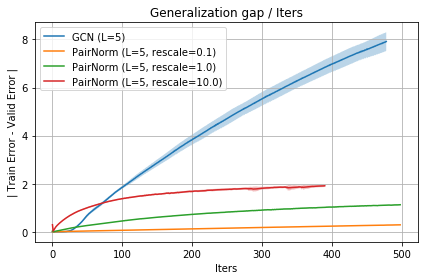

In [11]:
fig, axs = plt.subplots()

##########################
algorithm = 'GCN'
train_acc = []
y_vals = []
results_list = result_dict['GCN']
for result in results_list:
    if result.note.split()[0] == algorithm:
        train_acc.append(np.array(result.train_acc_record))
        train_loss = np.array(result.train_loss_record)
        valid_loss = np.array(result.loss_record)
        y_vals.append(np.abs(train_loss-valid_loss))

train_acc = np.mean(train_acc, axis=0)
x_stop = np.argmax(train_acc)

y_val_mean = np.mean(y_vals, axis=0)[:x_stop]
y_val_std = np.std(y_vals, axis=0)[:x_stop]
x_vals = np.arange(len(y_val_mean))

axs.plot(x_vals, y_val_mean, label='%s (L=%d)'%(algorithm, args.n_layers))
axs.fill_between(x_vals, y_val_mean-y_val_std, y_val_mean+y_val_std ,alpha=0.3)
##########################
algorithm='PairNorm'
for scale in [0.1, 1, 10]:
    results_list = result_dict['PairNorm%.1f'%scale]
    
    train_acc = []
    y_vals = []
    for result in results_list:
        train_acc.append(np.array(result.train_acc_record))
        train_loss = np.array(result.train_loss_record)
        valid_loss = np.array(result.loss_record)
        y_vals.append(np.abs(train_loss-valid_loss))

    train_acc = np.mean(train_acc, axis=0)
    x_stop = np.argmax(train_acc)

    y_val_mean = np.mean(y_vals, axis=0)[:x_stop]
    y_val_std = np.std(y_vals, axis=0)[:x_stop]
    x_vals = np.arange(len(y_val_mean))

    axs.plot(x_vals, y_val_mean, label='%s (L=%d, rescale=%.1f)'%(algorithm, args.n_layers, scale))
    axs.fill_between(x_vals, y_val_mean-y_val_std, y_val_mean+y_val_std ,alpha=0.3)
    
plt.title('Generalization gap / Iters')
axs.set_xlabel('Iters')
axs.set_ylabel('| Train Error - Valid Error |')

axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('generalization gap.pdf')

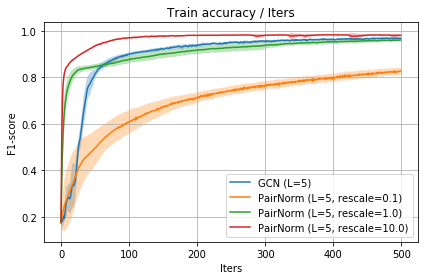

In [12]:
fig, axs = plt.subplots()

##########################
algorithm = 'GCN'
train_acc = []
y_vals = []
results_list = result_dict['GCN']
for result in results_list:
    if result.note.split()[0] == algorithm:
        y_vals.append(np.array(result.train_acc_record))

y_val_mean = np.mean(y_vals, axis=0)
y_val_std = np.std(y_vals, axis=0)
x_vals = np.arange(len(y_val_mean))

axs.plot(x_vals, y_val_mean, label='%s (L=%d)'%(algorithm, args.n_layers))
axs.fill_between(x_vals, y_val_mean-y_val_std, y_val_mean+y_val_std ,alpha=0.3)
##########################
algorithm='PairNorm'
for scale in [0.1, 1, 10]:
    results_list = result_dict['PairNorm%.1f'%scale]
    
    train_acc = []
    y_vals = []
    for result in results_list:
        y_vals.append(np.array(result.train_acc_record))

    y_val_mean = np.mean(y_vals, axis=0)
    y_val_std = np.std(y_vals, axis=0)
    x_vals = np.arange(len(y_val_mean))

    axs.plot(x_vals, y_val_mean, label='%s (L=%d, rescale=%.1f)'%(algorithm, args.n_layers, scale))
    axs.fill_between(x_vals, y_val_mean-y_val_std, y_val_mean+y_val_std ,alpha=0.3)
    
plt.title('Train accuracy / Iters')
axs.set_xlabel('Iters')
axs.set_ylabel('F1-score')

axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('generalization_gap_train.pdf')

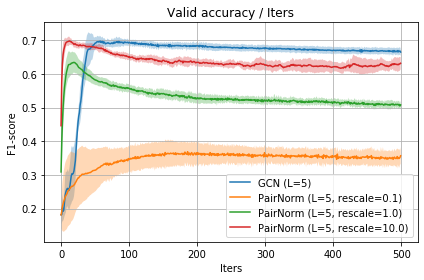

In [13]:
fig, axs = plt.subplots()

##########################
algorithm = 'GCN'
train_acc = []
y_vals = []
results_list = result_dict['GCN']
for result in results_list:
    if result.note.split()[0] == algorithm:
        y_vals.append(np.array(result.acc_record))

y_val_mean = np.mean(y_vals, axis=0)
y_val_std = np.std(y_vals, axis=0)
x_vals = np.arange(len(y_val_mean))

axs.plot(x_vals, y_val_mean, label='%s (L=%d)'%(algorithm, args.n_layers))
axs.fill_between(x_vals, y_val_mean-y_val_std, y_val_mean+y_val_std ,alpha=0.3)
##########################
algorithm='PairNorm'
for scale in [0.1, 1, 10]:
    results_list = result_dict['PairNorm%.1f'%scale]
    
    train_acc = []
    y_vals = []
    for result in results_list:
        y_vals.append(np.array(result.acc_record))

    y_val_mean = np.mean(y_vals, axis=0)
    y_val_std = np.std(y_vals, axis=0)
    x_vals = np.arange(len(y_val_mean))

    axs.plot(x_vals, y_val_mean, label='%s (L=%d, rescale=%.1f)'%(algorithm, args.n_layers, scale))
    axs.fill_between(x_vals, y_val_mean-y_val_std, y_val_mean+y_val_std ,alpha=0.3)
    
plt.title('Valid accuracy / Iters')
axs.set_xlabel('Iters')
axs.set_ylabel('F1-score')

axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('generalization_gap_valid.pdf')